In [1]:
import pandas
import category_encoders
from sklearn import dummy

from forml import project
from forml.stdlib.actor import wrapped
from forml.stdlib.operator import simple, debug

Titanic on ForML Tutorial
===========================

ForML framework allows to implement a ML solution using formalized project components and it's structured description. This is great for any project lifecycle management but less suitable for any exploratory type of work typical for Jupyter notebooks. In this tutorial we will demonstrate the ForML-jupyter interoperability showing it's features by examples.

Quick Start
-----------
Let's start with the quick run of the defined Titanic implementation as per the standard project structure within the `../src` directory tree. This approach assumes the project is already implemented and we just want to execute some of its modes from Jupyter. Later in the following section we will also demonstrate how to use forml for more exploratory work when the formal project structure might not exist yet.

The easiest way is to get the project handle using the `project.Artifact` class pointed to the project implementation:

In [2]:
PROJECT = project.Artifact(path='../src', package='titanic')

Now we have the project handle so we can easily execute it's particular mode using it's `.launcher` property. It can optionally be parametrized with a specific runner implementation passed as an item to the launcher property. Finally the method called on the launcher object triggers the project mode execution.

Let's execute the `train` mode on the `graphviz` runner to render the flow graph vizualization that you can see displayed bellow:

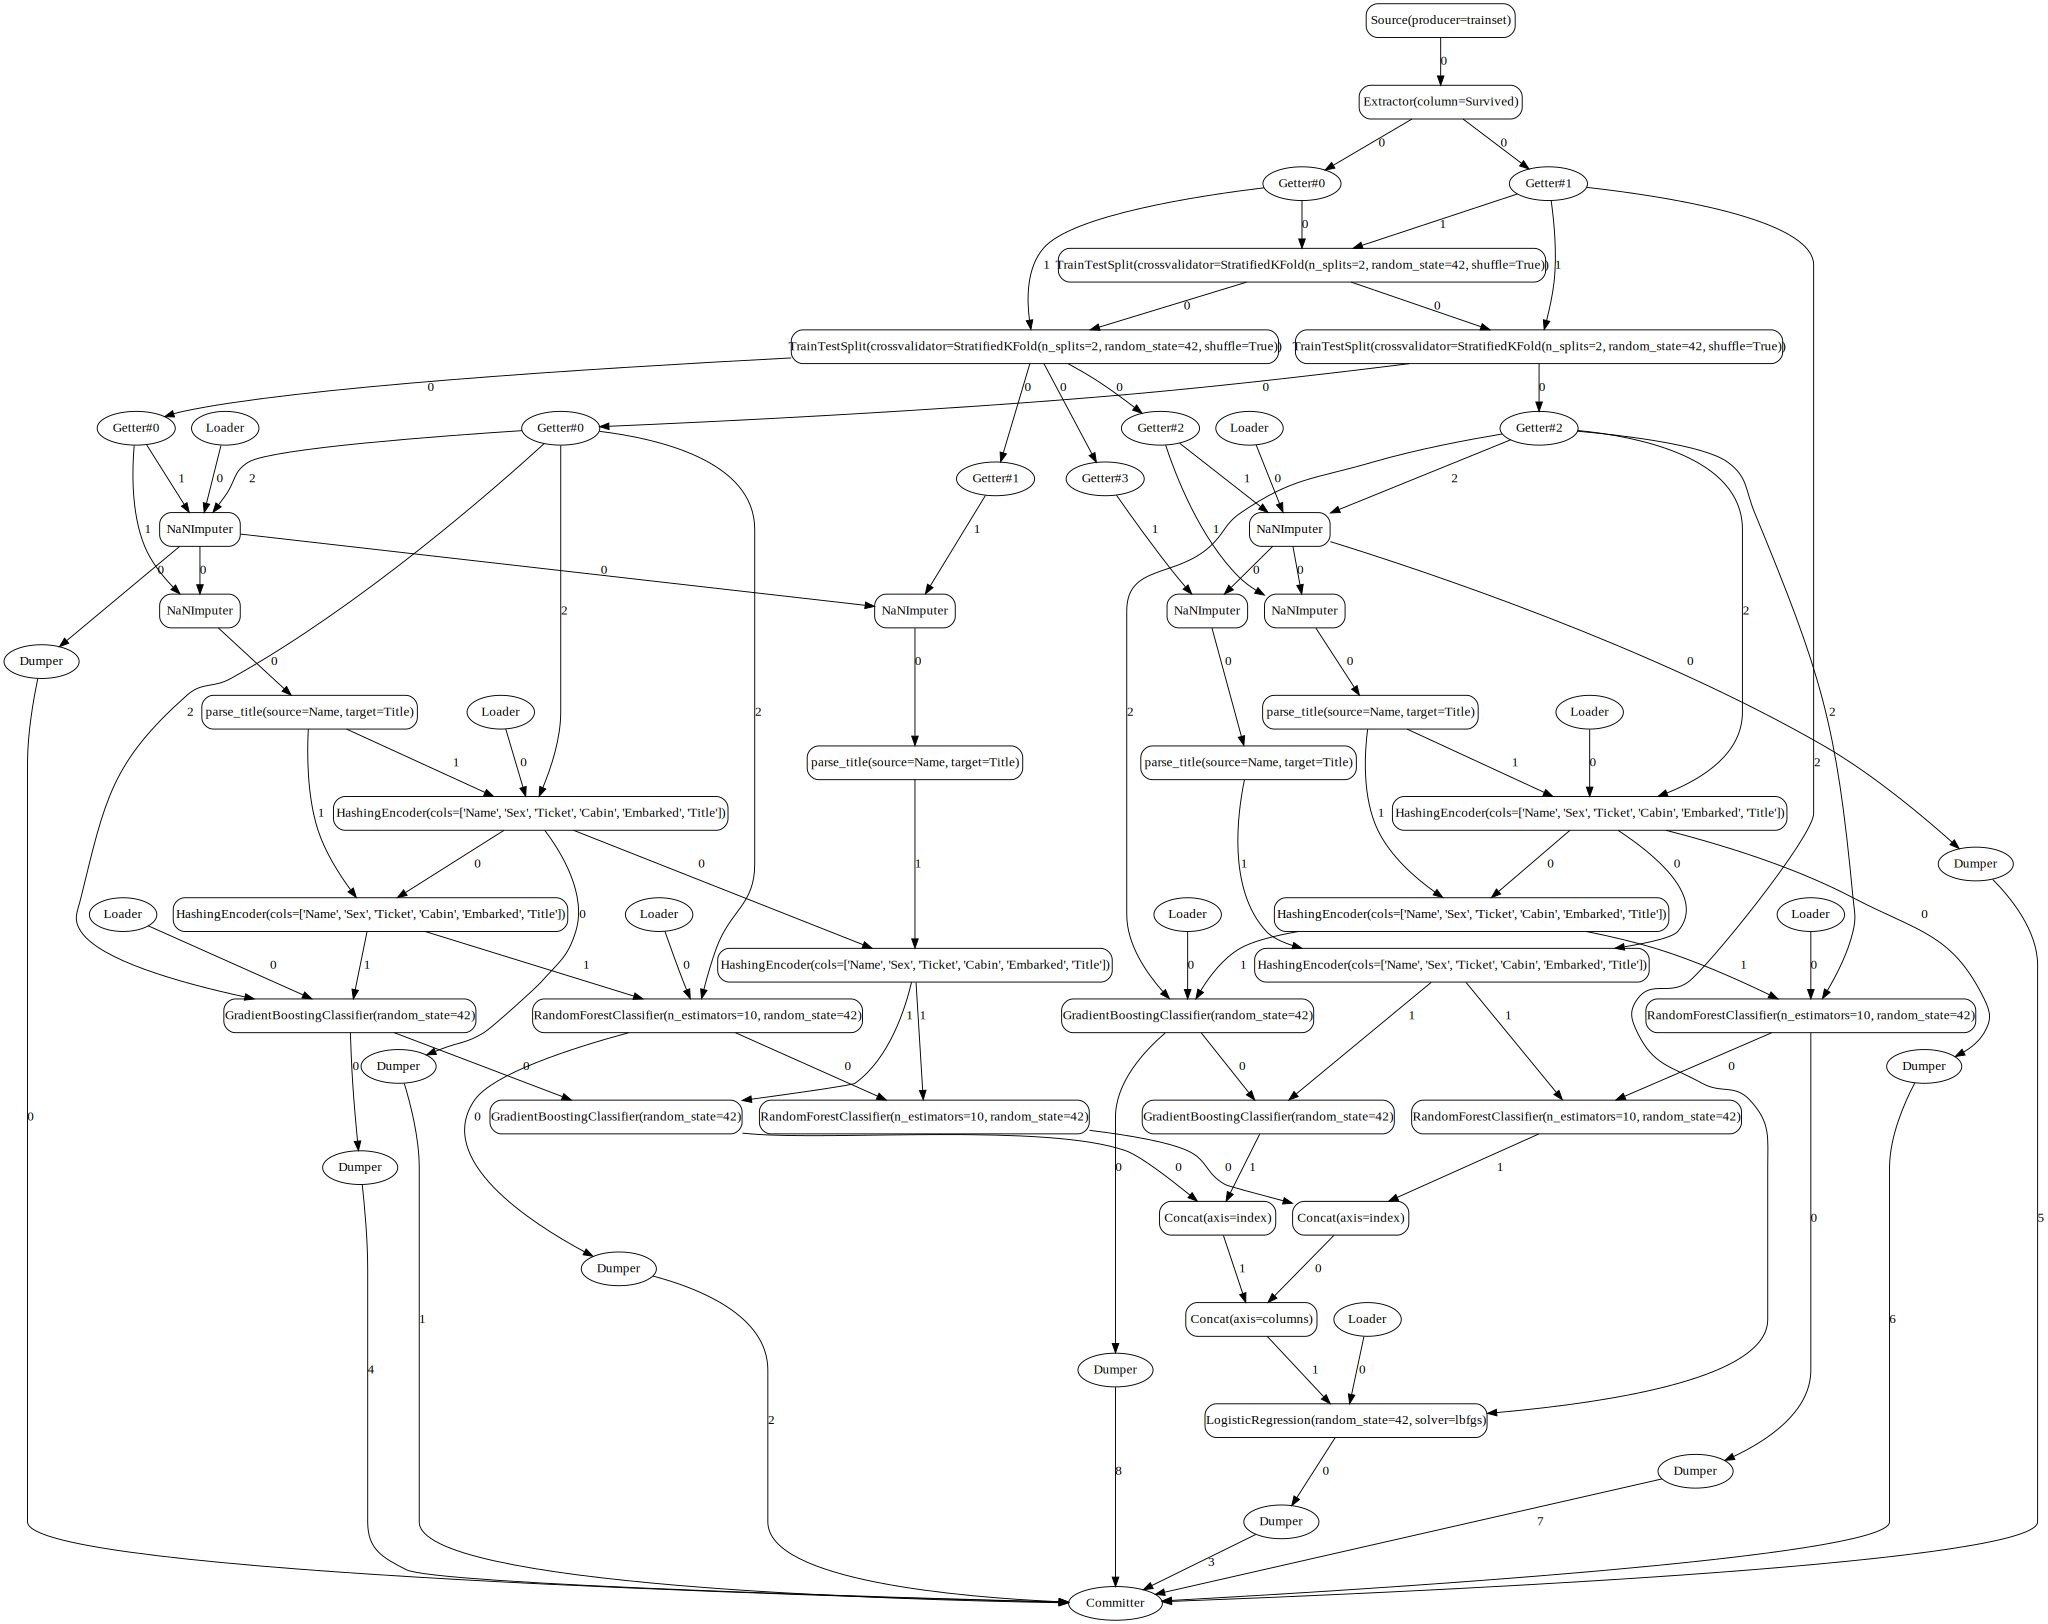

In [3]:
PROJECT.launcher['graphviz'].train()

Now lets run the `train` mode again but on the `dask` executor this time followed by executing the `predict` mode. Dask is the default runner so we don't need (but we can) to specify it explicitly:

In [4]:
PROJECT.launcher.train()
predictions = PROJECT.launcher['dask'].apply()
predictions[:10]

array([[0.61713544, 0.38286456],
       [0.61696831, 0.38303169],
       [0.61718967, 0.38281033],
       [0.61787081, 0.38212919],
       [0.61686284, 0.38313716],
       [0.61743323, 0.38256677],
       [0.61744046, 0.38255954],
       [0.61622198, 0.38377802],
       [0.61638259, 0.38361741],
       [0.6169622 , 0.3830378 ]])

Or we can run the `cvscore` mode to get the crossvalidation evaluation metric as per the project implementation:

In [5]:
PROJECT.launcher.cvscore()

0.6513740939099146

Exploration with ForML on Jupyter
-----------------------------------

Despite being strongly oriented on the formalized project structure, ForML also allows to engage snippets of code defined outside of any project and executing them within a pipeline. This is especially useful for the Jupyter style of work. It can even mix the two approaches - resuing some of the formal project components while supplying others inline.

Let's demonstrate this features by running the original `source` component (`../src/titanic/source`) through set of custom inline operators.

We start with reusing the `source` component from the actual project and running it through a dummy pipline with just the `Return` operator:

In [6]:
SOURCE = PROJECT.descriptor.source
PIPELINE = debug.Return()
SOURCE.bind(PIPELINE).launcher.train().head()

,label,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's now define custom stateless transformer operator for extracting a title from a name and use it in the pipeline exploring its output:

In [7]:
@simple.Mapper.operator
@wrapped.Function.actor
def parse_title(data: pandas.DataFrame, source: str, target: str) -> pandas.DataFrame:
    """Transformer extracting a person's title from the name string implemented as wrapped stateless function.
    """
    def get_title(name: str) -> str:
        """Auxiliary method for extracting the title.
        """
        if '.' in name:
            return name.split(',')[1].split('.')[0].strip()
        return 'Unknown'

    data[target] = data[source].map(get_title)
    return data

PIPELINE = parse_title(source='Name', target='Title')
SOURCE.bind(PIPELINE).launcher.train().head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Let's now attach a `HashingEncoder` (stateful operator) to the pipeline and run it again, this time using the `graphviz` runner to display the runtime graph:

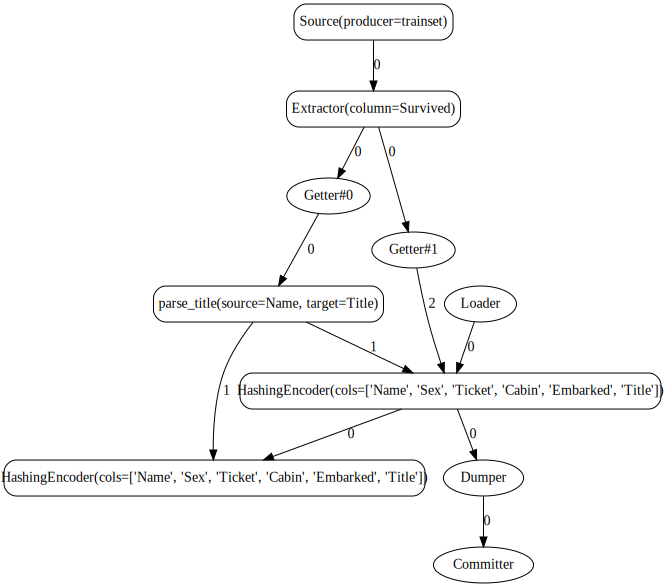

In [8]:
ENCODER = simple.Mapper.operator(wrapped.Class.actor(category_encoders.HashingEncoder, train='fit', apply='transform'))
PIPELINE >>= ENCODER(cols=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title'])
SOURCE.bind(PIPELINE).launcher['graphviz'].train()

Finally we add a `DummyClassifier` estimator and run the `train` mode followed by `apply` mode to generate the predictions:

In [9]:
DUMMY = simple.Consumer.operator(wrapped.Class.actor(dummy.DummyClassifier, train='fit', apply='predict_proba'))
PIPELINE >>= DUMMY()
SOURCE.bind(PIPELINE).launcher.train()
predictions = SOURCE.bind(PIPELINE).launcher.apply()
predictions[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])